# Face Recognition Using CNN

## Tentang dataset

> Data tersebut berisi gambar wajah yang telah dipotong dari 17 orang yang dibagi ke dalam Pelatihan dan pengujian. Model akan dilatih menggunakan CNN menggunakan gambar-gambar di folder Pelatihan dan kemudian menguji model dengan menggunakan gambar-gambar yang tidak terlihat dari folder pengujian, untuk memeriksa apakah model tersebut dapat mengenali nomor wajah, yaitu label yang diberikan kepada setiap wajah selama pelatihan gambar-gambar yang tidak terlihat atau tidak.n)

In [74]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
from tensorflow import keras
from keras.callbacks import Callback, EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import time

In [46]:
train_dir = r"Face Images/Face Images/Final Training Images"
test_dir = r"Face Images/Face Images/Final Testing Images"

## Explorasi data

### Mengecek jumlah data

In [25]:
# Fungsi untuk menghitung jumlah gambar per kelas
def count_images_per_class(directory):
    data_info = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            num_images = len([f for f in os.listdir(label_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
            data_info.append((label, num_images))
    return data_info

   Pegawai  Jumlah Foto
0    BE001           20
1    BE002           16
2    BE003           14
3   CEO001           15
4    CS001           17
5   CTO001           15
6    DO001           13
7    DO002           12
8    FE001           14
9    FE002           17
10   FE003           16
11   IS001           15
12   SA001           15
13   UI001           16
14   UI002           14
15   UX001           14
16   UX002           16


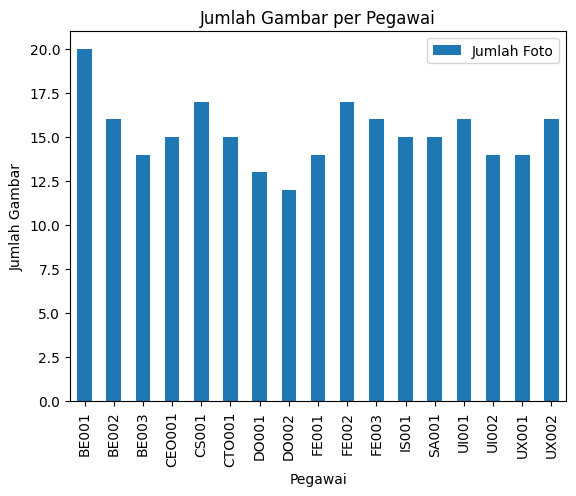

In [26]:
# Hitung jumlah gambar per kelas
data_info = count_images_per_class(train_dir)
df = pd.DataFrame(data_info, columns=['Pegawai', 'Jumlah Foto'])

# Tampilkan informasi jumlah gambar per kelas
print(df)

# Visualisasikan jumlah gambar per kelas
df.set_index('Pegawai').plot(kind='bar')
plt.xlabel('Pegawai')
plt.ylabel('Jumlah Gambar')
plt.title('Jumlah Gambar per Pegawai')
plt.show()

### Mengecek sample data tiap class

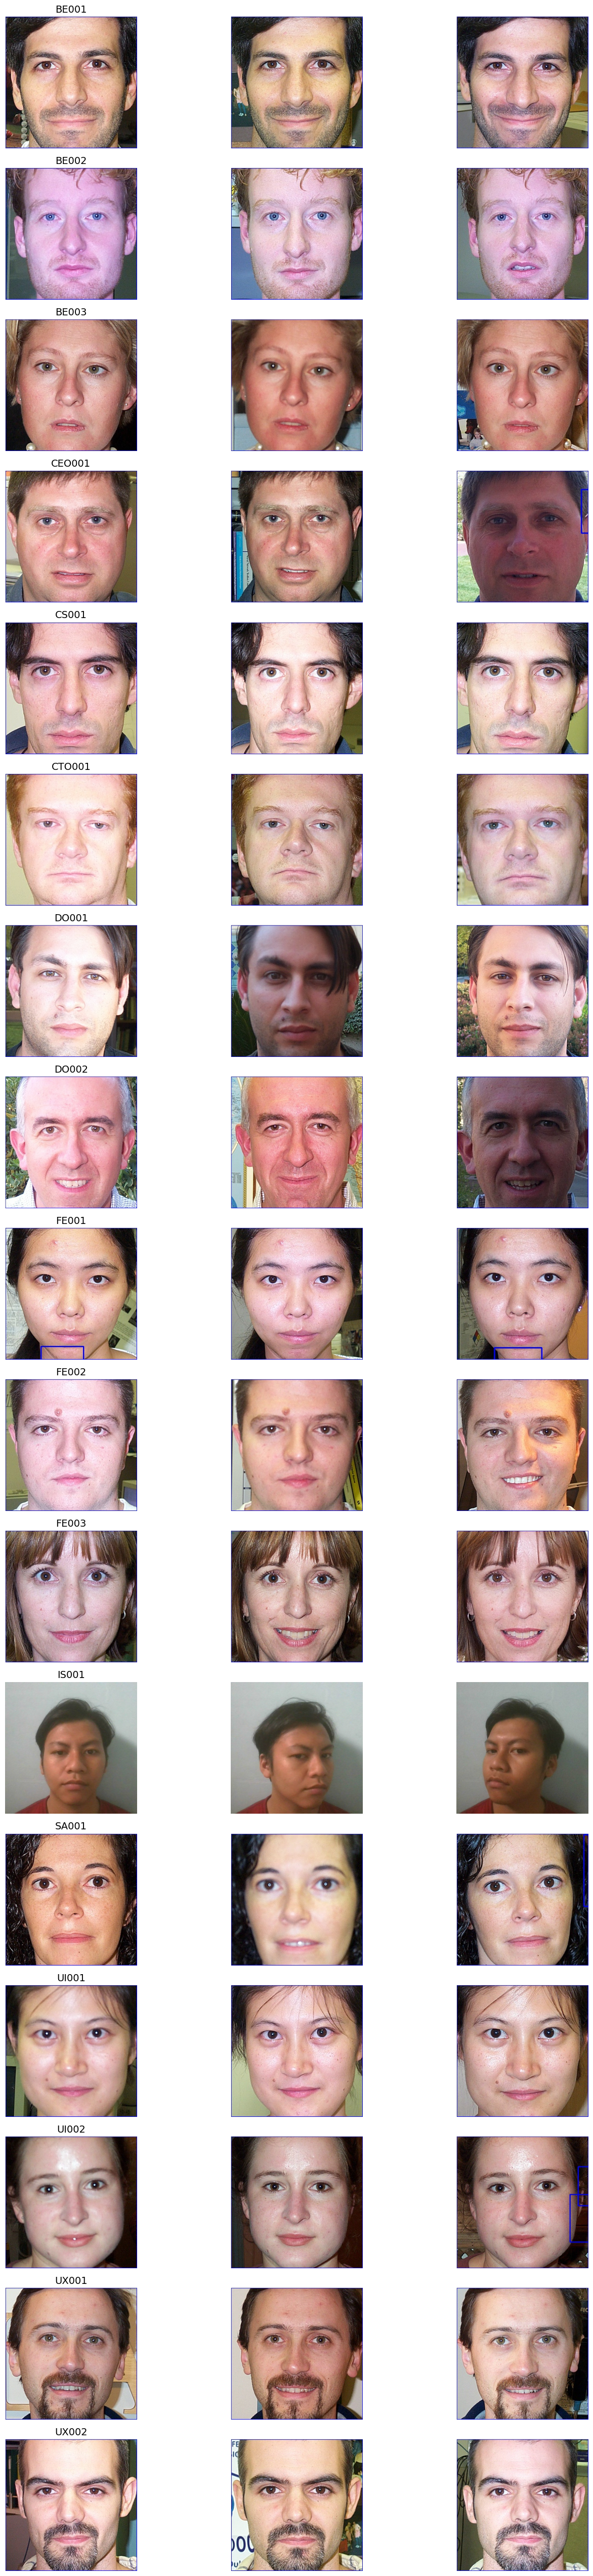

In [27]:
def show_images_from_folder(folder_path, num_images=3):
    """
    Menampilkan sejumlah gambar dari setiap subfolder di dalam folder_path.
    
    Parameters:
    - folder_path: Path ke folder utama yang berisi subfolder untuk setiap kelas.
    - num_images: Jumlah gambar yang akan ditampilkan dari setiap subfolder.
    """
    # Dapatkan daftar subfolder
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
    
    # Tentukan jumlah baris dan kolom untuk subplot
    num_classes = len(subfolders)
    num_cols = num_images
    num_rows = num_classes

    # Buat figure untuk plot
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten() if num_classes > 1 else [axes]

    for idx, subfolder in enumerate(subfolders):
        # Dapatkan nama kelas (subfolder)
        class_name = os.path.basename(subfolder)
        
        # Dapatkan daftar gambar dalam subfolder
        image_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith(('.png', '.jpg', '.jpeg'))]

        for jdx, image_file in enumerate(image_files[:num_images]):
            # Baca gambar menggunakan OpenCV
            image = cv2.imread(image_file)
            # Konversi dari BGR (OpenCV default) ke RGB (matplotlib default)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Tentukan indeks untuk subplot
            ax_idx = idx * num_cols + jdx
            
            # Tampilkan gambar di subplot
            axes[ax_idx].imshow(image)
            axes[ax_idx].axis('off')
            if jdx == 0:
                axes[ax_idx].set_title(class_name, fontsize=14)

    plt.tight_layout()
    plt.show()
# Tampilkan beberapa gambar dari setiap kelas di folder train
show_images_from_folder(train_images, num_images=3)

### Memeriksa ukuran gambar

In [20]:
# Fungsi untuk memeriksa ukuran gambar
def get_image_sizes(directory):
    image_sizes = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_name in os.listdir(label_dir):
                if image_name.endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(label_dir, image_name)
                    image = cv2.imread(image_path)
                    if image is not None:
                        image_sizes.append(image.shape[:2])
    return image_sizes

In [28]:
# Periksa ukuran gambar
image_sizes = get_image_sizes(train_dir)
size_df = pd.DataFrame(image_sizes, columns=['Height', 'Width'])

# Tampilkan informasi ukuran gambar
print(size_df.describe())

          Height      Width
count  259.00000  259.00000
mean   341.27027  341.27027
std     96.40232   96.40232
min    249.00000  249.00000
25%    305.00000  305.00000
50%    318.00000  318.00000
75%    334.50000  334.50000
max    720.00000  720.00000


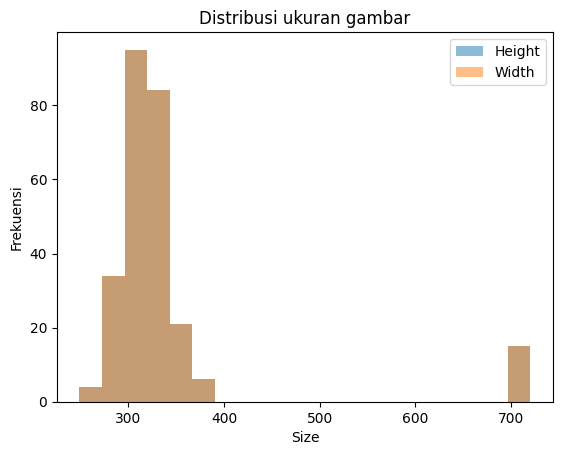

In [29]:
# Visualisasikan distribusi ukuran gambar
size_df.plot(kind='hist', alpha=0.5, bins=20)
plt.xlabel('Size')
plt.ylabel('Frekuensi')
plt.title('Distribusi ukuran gambar')
plt.show()

### Memeriksa distribusi pixel

In [30]:
# Fungsi untuk menghitung distribusi piksel
def calculate_pixel_distribution(image):
    chans = cv2.split(image)
    features = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = hist / hist.sum()
        features.append(hist)
    return features


In [31]:
# Hitung distribusi piksel untuk semua gambar
pixel_distributions = []
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    if os.path.isdir(label_dir):
        for image_name in os.listdir(label_dir):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(label_dir, image_name)
                image = cv2.imread(image_path)
                if image is not None:
                    distribution = calculate_pixel_distribution(image)
                    pixel_distributions.append((label, *distribution))

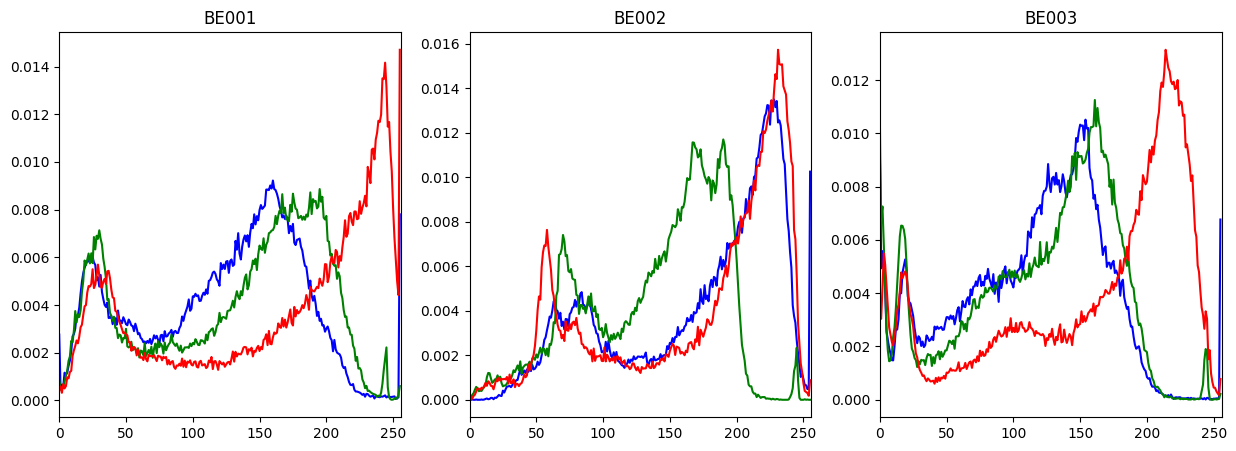

In [43]:
# Buat DataFrame untuk distribusi piksel
pixel_df = pd.DataFrame(pixel_distributions)

# Visualisasikan distribusi piksel untuk beberapa gambar (contoh)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, label in enumerate(df['Pegawai'].unique()[:3]): #Menggunakan 3 gambar saja
    example_image = os.path.join(train_dir, label, os.listdir(os.path.join(train_dir, label))[0])
    image = cv2.imread(example_image)
    chans = cv2.split(image)
    colors = ("b", "g", "r")
    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = hist / hist.sum()
        axes[i].plot(hist, color=color)
    axes[i].set_title(label)
    axes[i].set_xlim([0, 256])

plt.show()

## Membangun model

### Praproses data

In [110]:
# Data augmentation dan data generator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 259 images belonging to 17 classes.
Found 67 images belonging to 17 classes.


In [122]:
# training_data have numeric tag for each face
Train_class = train_generator.class_indices

# lets store them in a dictionary with swap for future reference
Result_class = {}
for value_tag, face_tag in zip(Train_class.values(),Train_class.keys()):
    Result_class[value_tag] = face_tag

In [121]:
# Printing class labels for each face
test_generator.class_indices

{'BE001': 0,
 'BE002': 1,
 'BE003': 2,
 'CEO001': 3,
 'CS001': 4,
 'CTO001': 5,
 'DO001': 6,
 'DO002': 7,
 'FE001': 8,
 'FE002': 9,
 'FE003': 10,
 'IS001': 11,
 'SA001': 12,
 'UI001': 13,
 'UI002': 14,
 'UX001': 15,
 'UX002': 16}

### Membangun & melatih model

In [81]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2

In [111]:
# Definisikan callback kustom untuk menghentikan pelatihan ketika akurasi > 96%
class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= 0.96:
            print(f"\nAkurasi validasi mencapai {logs.get('val_accuracy') * 100:.2f}%, menghentikan pelatihan!")
            self.model.stop_training = True

# Membangun model CNN
Model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),  # Regularisasi L2
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),  # Dropout layer untuk mengurangi overfitting
    Dense(train_generator.num_classes, activation='softmax')
])


# Kompilasi model
Model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Menggunakan Early stopping untuk mengurangi waktu pelatihan
call = CustomEarlyStopping()

# Mengukur waktu yang dibutuhkan oleh model untuk melatih
StartTime = time.time()

# Melatih model
history = Model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=20,
    callbacks=[call])

Endtime = time.time()
print('Total Training Time taken: ', round((Endtime - StartTime) / 60), 'Minutes')


Epoch 1/20
8/8 [==============================] - 7s 796ms/step - loss: 3.1351 - accuracy: 0.0977 - val_loss: 2.7816 - val_accuracy: 0.3750
Epoch 2/20
8/8 [==============================] - 6s 704ms/step - loss: 2.5919 - accuracy: 0.3216 - val_loss: 2.1157 - val_accuracy: 0.3750
Epoch 3/20
8/8 [==============================] - 6s 725ms/step - loss: 1.6177 - accuracy: 0.5595 - val_loss: 0.9708 - val_accuracy: 0.7969
Epoch 4/20
8/8 [==============================] - 7s 827ms/step - loss: 0.7399 - accuracy: 0.7891 - val_loss: 0.3733 - val_accuracy: 0.8750
Epoch 5/20
8/8 [==============================] - 6s 738ms/step - loss: 0.3569 - accuracy: 0.9295 - val_loss: 0.2473 - val_accuracy: 0.9375
Epoch 6/20
8/8 [==============================] - 6s 746ms/step - loss: 0.2108 - accuracy: 0.9604 - val_loss: 0.2677 - val_accuracy: 0.9375
Epoch 7/20
8/8 [==============================] - 6s 752ms/step - loss: 0.1265 - accuracy: 0.9648 - val_loss: 0.2838 - val_accuracy: 0.9375
Epoch 8/20
8/8 [====

In [112]:
# Simpan model
Model.save('Model_Face_Recognition.h5')

### Cek performa model

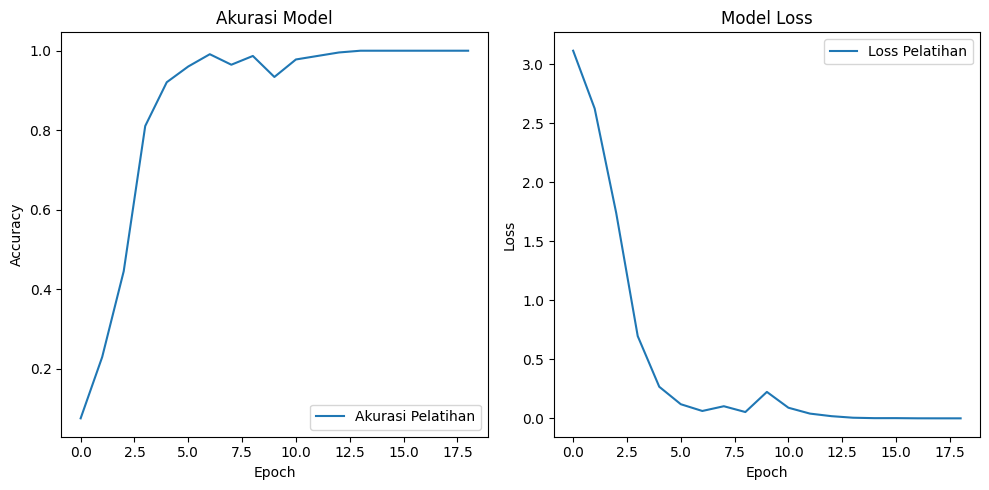

In [64]:
# Plotting accuracy and loss
plt.figure(figsize=(10, 5))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Pelatihan')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

Found 67 images belonging to 17 classes.
3/3 [==============================] - 0s 98ms/step


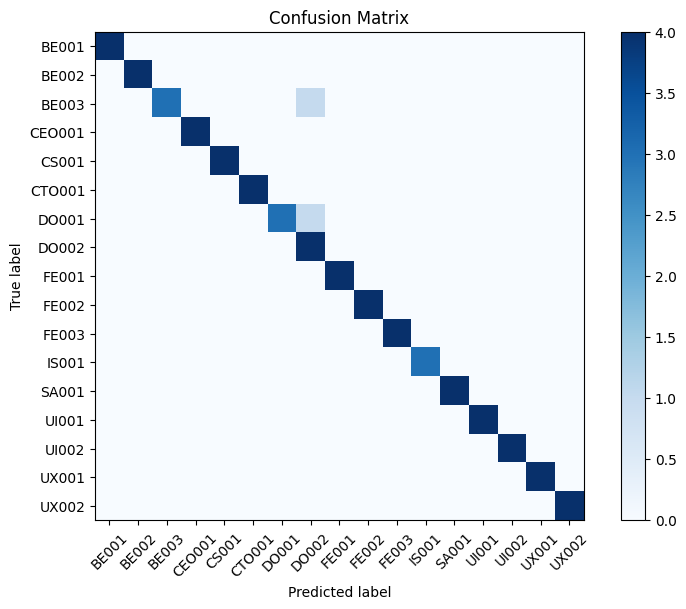

In [70]:
from sklearn.metrics import confusion_matrix
from keras.models import load_model

# Load model
model = load_model('face_recognition_model.h5')

# Data generator untuk test set
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Penting: jangan acak urutan gambar
)

# Prediksi kelas untuk data test
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Label yang sebenarnya untuk data test
true_classes = test_generator.classes

# Nama kelas
class_labels = list(test_generator.class_indices.keys())

# Membuat confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [72]:
from sklearn.metrics import classification_report

# Membuat classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)

# Print classification report
print(report)

              precision    recall  f1-score   support

       BE001       1.00      1.00      1.00         4
       BE002       1.00      1.00      1.00         4
       BE003       1.00      0.75      0.86         4
      CEO001       1.00      1.00      1.00         4
       CS001       1.00      1.00      1.00         4
      CTO001       1.00      1.00      1.00         4
       DO001       1.00      0.75      0.86         4
       DO002       0.67      1.00      0.80         4
       FE001       1.00      1.00      1.00         4
       FE002       1.00      1.00      1.00         4
       FE003       1.00      1.00      1.00         4
       IS001       1.00      1.00      1.00         3
       SA001       1.00      1.00      1.00         4
       UI001       1.00      1.00      1.00         4
       UI002       1.00      1.00      1.00         4
       UX001       1.00      1.00      1.00         4
       UX002       1.00      1.00      1.00         4

    accuracy              

### Menguji model menggunakan data test

In [128]:
# Muat model
model = load_model('Model_Face_Recognition.h5')

# Panggil salah satu data 
ImagePath=r"Face Images/Face Images/Final Testing Images/BE001/1face10.jpg"
test_image=image.load_img(ImagePath,target_size=(150, 150))
test_image=image.img_to_array(test_image)

# Prediksi kelas
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image,verbose=0)
#print(training_set.class_indices) 
print('Hasil prediksi: ',Result_class[np.argmax(result)])

Hasil prediksi:  BE001


In [129]:
# Hasil prediksi menggunakan banyak data
## Load semua gambar dari folder data testing
main_ = r"Face Images/Face Images/Final Testing Images"
img_paths = glob.glob(os.path.join(main_,'**','*.jpg'))

print(img_paths[0:5]) # every image will be a PIL object
print('*'*50)

for path in img_paths:
    test_image = image.load_img(path,target_size=(150,150))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image,axis =0)
    result = model.predict(test_image,verbose=0)
    print('Prediction: ',Result_class[np.argmax(result)])

['Face Images/Face Images/Final Testing Images\\BE001\\1face10.jpg', 'Face Images/Face Images/Final Testing Images\\BE001\\2face10.jpg', 'Face Images/Face Images/Final Testing Images\\BE001\\3face10.jpg', 'Face Images/Face Images/Final Testing Images\\BE001\\4face10.jpg', 'Face Images/Face Images/Final Testing Images\\BE002\\1face11.jpg']
**************************************************
Prediction:  BE001
Prediction:  BE001
Prediction:  BE001
Prediction:  BE001
Prediction:  BE002
Prediction:  BE002
Prediction:  BE002
Prediction:  BE002
Prediction:  BE003
Prediction:  BE003
Prediction:  BE003
Prediction:  BE003
Prediction:  CEO001
Prediction:  CEO001
Prediction:  CEO001
Prediction:  CEO001
Prediction:  CS001
Prediction:  CS001
Prediction:  CS001
Prediction:  CS001
Prediction:  CTO001
Prediction:  CTO001
Prediction:  CTO001
Prediction:  CTO001
Prediction:  DO001
Prediction:  DO001
Prediction:  DO001
Prediction:  CEO001
Prediction:  DO002
Prediction:  DO002
Prediction:  DO002
Prediction